In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyConv2d(6, 5, padding=2), nn.Sigmoid(),
                                 nn.AvgPool2d(2, stride=2),
                                 nn.LazyConv2d(16, 5), nn.Sigmoid(),
                                 nn.AvgPool2d(2, stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(120), nn.Sigmoid(),
                                 nn.LazyLinear(84), nn.Sigmoid(),
                                 nn.LazyLinear(num_classes))

In [15]:
trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=100.0, y=0.8750988924050633), Point(x=100.0, y=0.33621889343367345))

In [19]:

class LeNetCustom(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyConv2d(6, 5, padding=2), nn.Sigmoid(),
                                 nn.AvgPool2d(2, stride=2),
                                 nn.LazyConv2d(16, 5), nn.Sigmoid(),
                                 nn.AvgPool2d(2, stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(120), nn.ReLU(),
                                 nn.LazyLinear(84), nn.ReLU(),
                                 nn.LazyLinear(num_classes))
model = LeNetCustom(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=100.0, y=0.8946795886075949), Point(x=100.0, y=0.3000890719586441))

(Point(x=30.0, y=0.8987341772151899), Point(x=30.0, y=0.2838666952109035))

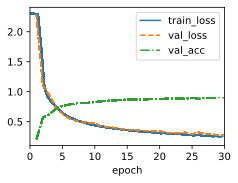

In [24]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyConv2d(96, 11, stride=4, padding=1), nn.ReLU(), nn.MaxPool2d(3, stride=2),
                                 nn.LazyConv2d(256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(3, stride=2),
                                 nn.LazyConv2d(384, 3, padding=1), nn.ReLU(),
                                 nn.LazyConv2d(384, 3, padding=1), nn.ReLU(),
                                 nn.LazyConv2d(256, 3, padding=1), nn.ReLU(),
                                 nn.MaxPool2d(3, stride=2), nn.Flatten(),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
                                 nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
#AlexNet().layer_summary((1, 1, 224, 224))
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224,224))
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=30.0, y=0.9192049050632911), Point(x=30.0, y=0.2299267480833621))

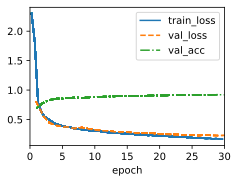

In [27]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, 3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers)

class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(*conv_blks, nn.Flatten(),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                 nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
model = VGG(arch=((1,16), (1,32), (2,64), (2,128), (2,128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=20.0, y=0.783623417721519), Point(x=20.0, y=0.5634878953046436))

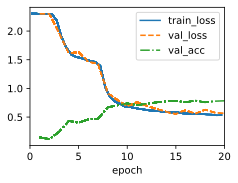

In [29]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
                         nn.LazyConv2d(out_channels, 1), nn.ReLU(),
                         nn.LazyConv2d(out_channels, 1), nn.ReLU())
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nin_block(96, 11, strides=4, padding=0), nn.MaxPool2d(3, stride=2),
                                 nin_block(256, 5, strides=1, padding=2), nn.MaxPool2d(3, stride=2),
                                 nin_block(384, 3, strides=1, padding=1), nn.MaxPool2d(3, stride=2),
                                 nn.Dropout(0.5),
                                 nin_block(num_classes, 3, strides=1, padding=1),
                                 nn.AdaptiveAvgPool2d((1, 1)),
                                 nn.Flatten())
        self.net.apply(d2l.init_cnn)
#NiN().layer_summary((1,1,224,224))
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

(Point(x=30.0, y=0.8912183544303798), Point(x=30.0, y=0.2917236294361609))

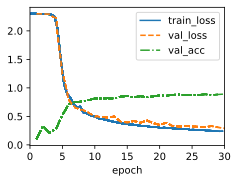

In [32]:
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        self.b1_1 = nn.LazyConv2d(c1, 1)
        self.b2_1 = nn.LazyConv2d(c2[0], 1)
        self.b2_2 = nn.LazyConv2d(c2[1], 3, padding=1)
        self.b3_1 = nn.LazyConv2d(c3[0], 1)
        self.b3_2 = nn.LazyConv2d(c3[1], 5, padding=2)
        self.b4_1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, 1)
    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, 7, stride=2, padding=3), nn.ReLU(),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(nn.LazyConv2d(64, 1), nn.ReLU(),
                             nn.LazyConv2d(192, 3, padding=1), nn.ReLU(),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                             Inception(128, (128, 192), (32, 96), 64),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                             Inception(160, (112, 224), (24, 64), 64),
                             Inception(128, (128, 256), (24, 64), 64),
                             Inception(112, (144, 288), (32, 64), 64),
                             Inception(256, (160, 320), (32, 128), 128),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                             Inception(384, (192, 384), (48, 128), 128),
                             nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(), self.b5(), nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]


(Point(x=20.0, y=0.9243473101265823), Point(x=20.0, y=0.348124678234888))

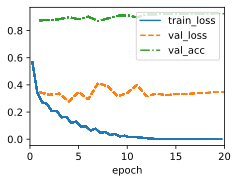

In [35]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, 3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, 3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, 1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y = F.relu(Y + X)
        return Y
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, 7, stride=2, padding=3), nn.LazyBatchNorm2d(), nn.ReLU(),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def block(self, num_rediduals, num_channels, first_block=False):
        blk = []
        for i in range(num_rediduals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
    def __init__(self, arch, lr=0.01, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                                  nn.Flatten(),
                                                  nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]

In [37]:
class ResNeXtBlock(nn.Module):
    def __init__(self, num_channels, group_size, bot_mul, use_1x1conv=False, strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, 1)
        self.conv2 = nn.LazyConv2d(bot_channels, 3, stride=strides, padding=1, groups=bot_channels//group_size)
        self.conv3 = nn.LazyConv2d(num_channels, 1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, 1, stride=strides)
            self.bn4 = nn.LazyBatchNorm2d() # ResNet没用bn
        else:
            self.conv4 = None
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
X.shape, blk(X).shape

(torch.Size([4, 32, 96, 96]), torch.Size([4, 32, 96, 96]))

(Point(x=20.0, y=0.9238528481012658), Point(x=20.0, y=0.24472792248559905))

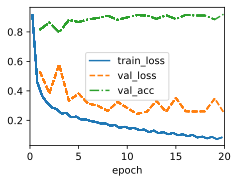

In [39]:
def conv_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), nn.LazyConv2d(num_channels, 3, padding=1))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), nn.LazyConv2d(num_channels, 1), nn.AvgPool2d(2, stride=2))
class DensNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, 7, stride=2, padding=3), nn.LazyBatchNorm2d(), nn.ReLU(),
                             nn.MaxPool2d(3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4,4,4,4), lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
        self.net.add_module('last', nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(),
                                                  nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
                                                  nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)
model = DensNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)
model.board.data['val_acc'][-1], model.board.data['val_loss'][-1]